# T81-558: Applications of Deep Neural Networks
**Module 4: Training for Tabular Data**
* Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/), McKelvey School of Engineering, [Washington University in St. Louis](https://engineering.wustl.edu/Programs/Pages/default.aspx)
* For more information visit the [class website](https://sites.wustl.edu/jeffheaton/t81-558/).

# Module Video Material

Main video lecture:

* [Part 4.1: Encoding a Feature Vector for Keras Deep Learning](https://www.youtube.com/watch?v=ATuyK_HWZgc&index=12&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN)
* [Part 4.2: Keras Multiclass Classification for Deep Neural Networks with ROC and AUC](https://www.youtube.com/watch?v=hXkZqGi5mB4&index=13&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN)
* [Part 4.3: Keras Regression for Deep Neural Networks with RMSE](https://www.youtube.com/watch?v=SIyMm5DFwQ8&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN)
* [Part 4.4: Backpropagation, Nesterov Momentum, and ADAM Neural Network Training](https://www.youtube.com/watch?v=iMyGyZYE9Lc)
* [Part 4.5: Neural Network RMSE and Log Loss Error Calculation from Scratch](https://www.youtube.com/watch?v=iMyGyZYE9Lc)

# Part 4.1: Encoding a Feature Vector for Keras Deep Learning

Neural networks can accept many types of data.  We will begin with tabular data, where there are well defined rows and columns.  This is the sort of data you would typically see in Microsoft Excel.  An example of tabular data is shown below.

Neural networks require numeric input.  This numeric form is called a feature vector.  Each row of training data typically becomes one vector.  The individual input neurons each receive one feature (or column) from this vector.  In this section, we will see how to encode the following tabular data into a feature vector.

In [1]:
import pandas as pd

df = pd.read_csv(
    "https://data.heatonresearch.com/data/t81-558/jh-simple-dataset.csv",
    na_values=['NA','?'])

display(df[0:5])

,id,job,area,income,aspect,subscriptions,dist_healthy,save_rate,dist_unhealthy,age,pop_dense,retail_dense,crime,product
0,1,vv,c,50876.0,13.100000,1,9.017895,35,11.738935,49,0.885827,0.492126,0.071100,b
1,2,kd,c,60369.0,18.625000,2,7.766643,59,6.805396,51,0.874016,0.342520,0.400809,c
2,3,pe,c,55126.0,34.766667,1,3.632069,6,13.671772,44,0.944882,0.724409,0.207723,b
3,4,11,c,51690.0,15.808333,1,5.372942,16,4.333286,50,0.889764,0.444882,0.361216,b
4,5,kl,d,28347.0,40.941667,3,3.822477,20,5.967121,38,0.744094,0.661417,0.068033,a


The following observations can be made from the above data:
* The target column is the column that you seek to predict.  There are several candidates here.  However, we will initially use product.  This field specifies what product someone bought.
* There is an ID column.  This column should not be fed into the neural network as it contains no information useful for prediction.
* Many of these fields are numeric and might not require any further processing.
* The income column does have some missing values.
* There are categorical values: job, area, and product.

To begin with, we will convert the job code into dummy variables.

In [2]:
dummies = pd.get_dummies(df['job'],prefix="job")
print(dummies.shape)
display(dummies[0:10])

(2000, 33)


,job_11,job_al,job_am,job_ax,job_bf,job_by,job_cv,job_de,job_dz,job_e2,...,job_pe,job_po,job_pq,job_pz,job_qp,job_qw,job_rn,job_sa,job_vv,job_zz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


Because there are 33 different job codes, there are 33 dummy variables.  We also specified a prefix, because the job codes (such as "ax") are not that meaningful by themselves.  Something such as "job_ax" also tells us the origin of this field.

Next, we must merge these dummies back into the main data frame.  We also drop the original "job" field, as it is now represented by the dummies. 

In [3]:
df = pd.concat([df,dummies],axis=1)
df.drop('job', axis=1, inplace=True)
display(df[0:10])

,id,area,income,aspect,subscriptions,dist_healthy,save_rate,dist_unhealthy,age,pop_dense,...,job_pe,job_po,job_pq,job_pz,job_qp,job_qw,job_rn,job_sa,job_vv,job_zz
0,1,c,50876.0,13.100000,1,9.017895,35,11.738935,49,0.885827,...,0,0,0,0,0,0,0,0,1,0
1,2,c,60369.0,18.625000,2,7.766643,59,6.805396,51,0.874016,...,0,0,0,0,0,0,0,0,0,0
2,3,c,55126.0,34.766667,1,3.632069,6,13.671772,44,0.944882,...,1,0,0,0,0,0,0,0,0,0
3,4,c,51690.0,15.808333,1,5.372942,16,4.333286,50,0.889764,...,0,0,0,0,0,0,0,0,0,0
4,5,d,28347.0,40.941667,3,3.822477,20,5.967121,38,0.744094,...,0,0,0,0,0,0,0,0,0,0
5,6,c,70854.0,40.400000,1,14.893343,87,20.340593,43,0.866142,...,0,0,0,0,0,0,0,0,0,0
6,7,d,38726.0,30.975000,3,3.822477,33,9.480399,39,0.976378,...,0,0,0,0,0,0,0,0,0,0
7,8,a,55162.0,26.966667,2,4.312097,17,29.219896,44,1.000000,...,0,0,0,0,0,0,0,0,0,0
8,9,c,67311.0,32.383333,0,25.093772,169,10.927357,45,0.952756,...,0,0,0,0,0,0,0,0,0,0
9,10,a,63344.0,38.233333,1,2.816034,3,21.915695,42,0.897638,...,1,0,0,0,0,0,0,0,0,0


We also introduce dummy variables for the area column.

In [4]:
df = pd.concat([df,pd.get_dummies(df['area'],prefix="area")],axis=1)
df.drop('area', axis=1, inplace=True)
display(df[0:10])

,id,income,aspect,subscriptions,dist_healthy,save_rate,dist_unhealthy,age,pop_dense,retail_dense,...,job_qp,job_qw,job_rn,job_sa,job_vv,job_zz,area_a,area_b,area_c,area_d
0,1,50876.0,13.100000,1,9.017895,35,11.738935,49,0.885827,0.492126,...,0,0,0,0,1,0,0,0,1,0
1,2,60369.0,18.625000,2,7.766643,59,6.805396,51,0.874016,0.342520,...,0,0,0,0,0,0,0,0,1,0
2,3,55126.0,34.766667,1,3.632069,6,13.671772,44,0.944882,0.724409,...,0,0,0,0,0,0,0,0,1,0
3,4,51690.0,15.808333,1,5.372942,16,4.333286,50,0.889764,0.444882,...,0,0,0,0,0,0,0,0,1,0
4,5,28347.0,40.941667,3,3.822477,20,5.967121,38,0.744094,0.661417,...,0,0,0,0,0,0,0,0,0,1
5,6,70854.0,40.400000,1,14.893343,87,20.340593,43,0.866142,0.673228,...,0,0,0,0,0,0,0,0,1,0
6,7,38726.0,30.975000,3,3.822477,33,9.480399,39,0.976378,0.874016,...,0,0,0,0,0,0,0,0,0,1
7,8,55162.0,26.966667,2,4.312097,17,29.219896,44,1.000000,0.724409,...,0,0,0,0,0,0,1,0,0,0
8,9,67311.0,32.383333,0,25.093772,169,10.927357,45,0.952756,0.681102,...,0,0,0,0,0,0,0,0,1,0
9,10,63344.0,38.233333,1,2.816034,3,21.915695,42,0.897638,0.724409,...,0,0,0,0,0,0,1,0,0,0


The last remaining transformation is to fill in missing income values. 

In [5]:
med = df['income'].median()
df['income'] = df['income'].fillna(med)

There are more advanced ways of filling in missing values, but they require more analysis.  The idea would be to see if another field might give a hint as to what the income were.  For example, it might be beneficial to calculate a median income for each of the areas or job categories.  This is something to keep in mind for the class Kaggle competition.

At this point, the Pandas dataframe is ready to be converted to Numpy for neural network training. We need to know a list of the columns that will make up *x* (the predictors or inputs) and *y* (the target). 

The complete list of columns is:

In [6]:
print(list(df.columns))

['id', 'income', 'aspect', 'subscriptions', 'dist_healthy', 'save_rate', 'dist_unhealthy', 'age', 'pop_dense', 'retail_dense', 'crime', 'product', 'job_11', 'job_al', 'job_am', 'job_ax', 'job_bf', 'job_by', 'job_cv', 'job_de', 'job_dz', 'job_e2', 'job_f8', 'job_gj', 'job_gv', 'job_kd', 'job_ke', 'job_kl', 'job_kp', 'job_ks', 'job_kw', 'job_mm', 'job_nb', 'job_nn', 'job_ob', 'job_pe', 'job_po', 'job_pq', 'job_pz', 'job_qp', 'job_qw', 'job_rn', 'job_sa', 'job_vv', 'job_zz', 'area_a', 'area_b', 'area_c', 'area_d']


This includes both the target and predictors.  We need a list with the target removed.  We also remove **id** because it is not useful for prediction.

In [7]:
x_columns = df.columns.drop('product').drop('id')
print(list(x_columns))

['income', 'aspect', 'subscriptions', 'dist_healthy', 'save_rate', 'dist_unhealthy', 'age', 'pop_dense', 'retail_dense', 'crime', 'job_11', 'job_al', 'job_am', 'job_ax', 'job_bf', 'job_by', 'job_cv', 'job_de', 'job_dz', 'job_e2', 'job_f8', 'job_gj', 'job_gv', 'job_kd', 'job_ke', 'job_kl', 'job_kp', 'job_ks', 'job_kw', 'job_mm', 'job_nb', 'job_nn', 'job_ob', 'job_pe', 'job_po', 'job_pq', 'job_pz', 'job_qp', 'job_qw', 'job_rn', 'job_sa', 'job_vv', 'job_zz', 'area_a', 'area_b', 'area_c', 'area_d']


### Generate X and Y for a Classification Neural Network

We can now generate *x* and *y*.  Note, this is how we generate y for a classification problem.  Regression would not use dummies and would simply encode the numeric value of the target.

In [8]:
# Convert to numpy - Classification
x_columns = df.columns.drop('product').drop('id')
x = df[x_columns].values
dummies = pd.get_dummies(df['product']) # Classification
products = dummies.columns
y = dummies.values

We can display the *x* and *y* matrices.

In [9]:
print(x)
print(y)

[[5.08760000e+04 1.31000000e+01 1.00000000e+00 ... 0.00000000e+00
  1.00000000e+00 0.00000000e+00]
 [6.03690000e+04 1.86250000e+01 2.00000000e+00 ... 0.00000000e+00
  1.00000000e+00 0.00000000e+00]
 [5.51260000e+04 3.47666667e+01 1.00000000e+00 ... 0.00000000e+00
  1.00000000e+00 0.00000000e+00]
 ...
 [2.85950000e+04 3.94250000e+01 3.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.00000000e+00]
 [6.79490000e+04 5.73333333e+00 0.00000000e+00 ... 0.00000000e+00
  1.00000000e+00 0.00000000e+00]
 [6.14670000e+04 1.68916667e+01 0.00000000e+00 ... 0.00000000e+00
  1.00000000e+00 0.00000000e+00]]
[[0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]]


The x and y values are now ready for a neural network.  Make sure that you construct the neural network for a classification problem.  Specifically,

* Classification neural networks have an output neuron count equal to the number of classes.
* Classification neural networks should use **categorical_crossentropy** and a **softmax** activation function on the output layer.

### Generate X and Y for a Regression Neural Network

For a regression neural network, the *x* values are generated the same.  However, *y* does not use dummies.  Make sure to replace **income** with your actual target.

In [10]:
y = df['income'].values

# Part 4.2: Keras Multiclass Classification for Deep Neural Networks with ROC and AUC

* **Binary Classification** - Classification between two possibilities (positive and negative).  Common in medical testing, does the person have the disease (positive) or not (negative).
* **Classification** - Classification between more than 2.  The iris dataset (3-way classification).
* **Regression** - Numeric prediction.  How many MPG does a car get? (covered in next video)

In this class session we will look at some visualizations for all three.


It is important to evaluate the level of error in the results produced by a neural network.  In this part we will look at how to evaluate error for both classification and regression neural networks.

### Binary Classification

Binary classification is used to create a model that classifies between only two classes.  These two classes are often called "positive" and "negative".  Consider the following program that uses the [wcbreast_wdbc dataset](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/datasets_wcbc.ipynb) to classify if a breast tumor is cancerous (malignant) or not (benign).  

In [11]:
import pandas as pd

df = pd.read_csv(
    "https://data.heatonresearch.com/data/t81-558/wcbreast_wdbc.csv",
    na_values=['NA','?'])

display(df[0:5])

,id,diagnosis,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,...,worst_radius,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### ROC Curves

ROC curves can be a bit confusing.  However, they are very common.  It is important to know how to read them.  Even their name is confusing.  Do not worry about their name, it comes from electrical engineering (EE).

Binary classification is common in medical testing.  Often you want to diagnose if someone has a disease.  This can lead to two types of errors, know as false positives and false negatives:

* **False Positive** - Your test (neural network) indicated that the patient had the disease; however, the patient did not have the disease.
* **False Negative** - Your test (neural network) indicated that the patient did not have the disease; however, the patient did have the disease.
* **True Positive** - Your test (neural network) correctly identified that the patient had the disease.
* **True Negative** - Your test (neural network) correctly identified that the patient did not have the disease.

Types of errors:

![Type of Error](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_4_errors.png "Type of Error")

Neural networks classify in terms of probability of it being positive. However, at what probability do you give a positive result?  Is the cutoff 50%? 90%?  Where you set this cutoff is called the threshold.  Anything above the cutoff is positive, anything below is negative.  Setting this cutoff allows the model to be more sensitive or specific:

More info on Sensitivity vs Specificity: [Khan Academy](https://www.youtube.com/watch?v=Z5TtopYX1Gc)

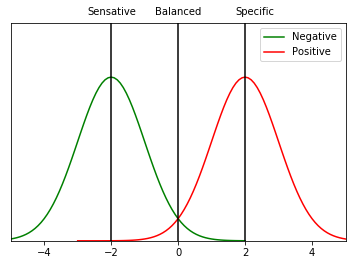

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

mu1 = -2
mu2 = 2
variance = 1
sigma = math.sqrt(variance)
x1 = np.linspace(mu1 - 5*sigma, mu1 + 4*sigma, 100)
x2 = np.linspace(mu2 - 5*sigma, mu2 + 4*sigma, 100)
plt.plot(x1, stats.norm.pdf(x1, mu1, sigma)/1,color="green")
plt.plot(x2, stats.norm.pdf(x2, mu2, sigma)/1,color="red")
plt.axvline(x=-2,color="black")
plt.axvline(x=0,color="black")
plt.axvline(x=+2,color="black")
plt.text(-2.7,0.55,"Sensative")
plt.text(-0.7,0.55,"Balanced")
plt.text(1.7,0.55,"Specific")
plt.ylim([0,0.53])
plt.xlim([-5,5])
plt.legend(['Negative','Positive'])
plt.yticks([])
#plt.set_yticklabels([])
plt.show()

In [13]:
from scipy.stats import zscore

# Prepare data - apply z-score to ALL x columns
# Only do this if you have no categoricals (and are sure you want to use z-score across the board)
x_columns = df.columns.drop('diagnosis').drop('id')
for col in x_columns:
    df[col] = zscore(df[col])

# Convert to numpy - Regression
x = df[x_columns].values
y = df['diagnosis'].map({'M':1,"B":0}) # Binary classification, M is 1 and B is 0

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, _ = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

### ROC Chart Example

In [15]:
# Classification neural network
import numpy as np
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(    
    x, y, test_size=0.25, random_state=42)

model = Sequential()
model.add(Dense(100, input_dim=x.shape[1], activation='relu',kernel_initializer='random_normal'))
model.add(Dense(50,activation='relu',kernel_initializer='random_normal'))
model.add(Dense(25,activation='relu',kernel_initializer='random_normal'))
model.add(Dense(1,activation='linear',kernel_initializer='random_normal'))
model.compile(loss='binary_crossentropy', 
              optimizer=tensorflow.keras.optimizers.Adam(),
              metrics =['accuracy'])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, 
    patience=5, verbose=1, mode='auto', restore_best_weights=True)
model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=1000)


Train on 426 samples, validate on 143 samples
Epoch 1/1000
426/426 - 0s - loss: 1.4110 - accuracy: 0.6291 - val_loss: 0.9715 - val_accuracy: 0.6224
Epoch 2/1000
426/426 - 0s - loss: 0.7830 - accuracy: 0.6362 - val_loss: 0.5208 - val_accuracy: 0.6853
Epoch 3/1000
426/426 - 0s - loss: 0.4032 - accuracy: 0.7746 - val_loss: 0.2300 - val_accuracy: 0.8811
Epoch 4/1000
426/426 - 0s - loss: 0.2238 - accuracy: 0.9249 - val_loss: 0.2216 - val_accuracy: 0.9510
Epoch 5/1000
426/426 - 0s - loss: 0.1574 - accuracy: 0.9531 - val_loss: 0.0985 - val_accuracy: 0.9580
Epoch 6/1000
426/426 - 0s - loss: 0.0948 - accuracy: 0.9671 - val_loss: 0.0770 - val_accuracy: 0.9650
Epoch 7/1000
426/426 - 0s - loss: 0.0749 - accuracy: 0.9718 - val_loss: 0.0663 - val_accuracy: 0.9720
Epoch 8/1000
426/426 - 0s - loss: 0.0643 - accuracy: 0.9789 - val_loss: 0.0596 - val_accuracy: 0.9790
Epoch 9/1000
426/426 - 0s - loss: 0.0568 - accuracy: 0.9812 - val_loss: 0.0581 - val_accuracy: 0.9790
Epoch 10/1000
426/426 - 0s - loss: 0

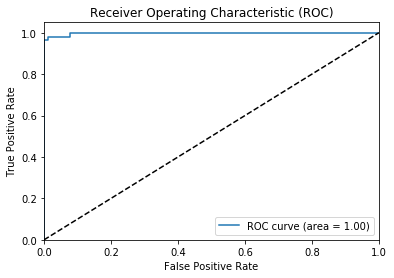

In [16]:
pred = model.predict(x_test)
plot_roc(pred,y_test)

### Multiclass Classification Error Metrics

The following sections will examine several metrics for evaluating classification error. The following classification neural network will be used to evaluate.

In [17]:
import pandas as pd
from scipy.stats import zscore

# Read the data set
df = pd.read_csv(
    "https://data.heatonresearch.com/data/t81-558/jh-simple-dataset.csv",
    na_values=['NA','?'])

# Generate dummies for job
df = pd.concat([df,pd.get_dummies(df['job'],prefix="job")],axis=1)
df.drop('job', axis=1, inplace=True)

# Generate dummies for area
df = pd.concat([df,pd.get_dummies(df['area'],prefix="area")],axis=1)
df.drop('area', axis=1, inplace=True)

# Missing values for income
med = df['income'].median()
df['income'] = df['income'].fillna(med)

# Standardize ranges
df['income'] = zscore(df['income'])
df['aspect'] = zscore(df['aspect'])
df['save_rate'] = zscore(df['save_rate'])
df['age'] = zscore(df['age'])
df['subscriptions'] = zscore(df['subscriptions'])

# Convert to numpy - Classification
x_columns = df.columns.drop('product').drop('id')
x = df[x_columns].values
dummies = pd.get_dummies(df['product']) # Classification
products = dummies.columns
y = dummies.values

In [18]:
# Classification neural network
import numpy as np
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(    
    x, y, test_size=0.25, random_state=42)

model = Sequential()
model.add(Dense(100, input_dim=x.shape[1], activation='relu',kernel_initializer='random_normal'))
model.add(Dense(50,activation='relu',kernel_initializer='random_normal'))
model.add(Dense(25,activation='relu',kernel_initializer='random_normal'))
model.add(Dense(y.shape[1],activation='softmax',kernel_initializer='random_normal'))
model.compile(loss='categorical_crossentropy', 
              optimizer=tensorflow.keras.optimizers.Adam(),
              metrics =['accuracy'])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, 
                        verbose=1, mode='auto', restore_best_weights=True)
model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=1000)


Train on 1500 samples, validate on 500 samples
Epoch 1/1000
1500/1500 - 0s - loss: 1.5276 - accuracy: 0.4233 - val_loss: 1.1440 - val_accuracy: 0.4980
Epoch 2/1000
1500/1500 - 0s - loss: 1.1437 - accuracy: 0.4760 - val_loss: 1.0882 - val_accuracy: 0.4980
Epoch 3/1000
1500/1500 - 0s - loss: 1.0790 - accuracy: 0.4967 - val_loss: 1.0278 - val_accuracy: 0.5620
Epoch 4/1000
1500/1500 - 0s - loss: 0.9731 - accuracy: 0.5840 - val_loss: 0.9328 - val_accuracy: 0.6040
Epoch 5/1000
1500/1500 - 0s - loss: 0.8636 - accuracy: 0.6520 - val_loss: 0.8839 - val_accuracy: 0.6200
Epoch 6/1000
1500/1500 - 0s - loss: 0.8013 - accuracy: 0.6813 - val_loss: 0.8413 - val_accuracy: 0.6720
Epoch 7/1000
1500/1500 - 0s - loss: 0.7762 - accuracy: 0.6747 - val_loss: 0.8241 - val_accuracy: 0.6480
Epoch 8/1000
1500/1500 - 0s - loss: 0.7570 - accuracy: 0.6833 - val_loss: 0.7892 - val_accuracy: 0.6960
Epoch 9/1000
1500/1500 - 0s - loss: 0.7321 - accuracy: 0.6973 - val_loss: 0.7808 - val_accuracy: 0.6720
Epoch 10/1000
150

### Calculate Classification Accuracy
 
Accuracy is the number of rows where the neural network correctly predicted the target class.  Accuracy is only used for classification, not regression.

$ accuracy = \frac{c}{N} $

Where $c$ is the number correct and $N$ is the size of the evaluated set (training or validation). Higher accuracy numbers are desired.

As we just saw, by default, Keras will return the percent probability for each class. We can change these prediction probabilities into the actual iris predicted with **argmax**.

In [19]:
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1) # raw probabilities to chosen class (highest probability)

Now that we have the actual iris flower predicted, we can calculate the percent accuracy (how many were correctly classified).

In [20]:
from sklearn import metrics

y_compare = np.argmax(y_test,axis=1) 
score = metrics.accuracy_score(y_compare, pred)
print("Accuracy score: {}".format(score))

Accuracy score: 0.71


### Calculate Classification Log Loss

Accuracy is like a final exam with no partial credit.  However, neural networks can predict a probability of each of the target classes.  Neural networks will give high probabilities to predictions that are more likely.  Log loss is an error metric that penalizes confidence in wrong answers. Lower log loss values are desired.

The following code shows the output of predict_proba:


In [21]:
from IPython.display import display

# Don't display numpy in scientific notation
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

# Generate predictions
pred = model.predict(x_test)

print("Numpy array of predictions")
display(pred[0:5])

print("As percent probability")
print(pred[0]*100)

score = metrics.log_loss(y_test, pred)
print("Log loss score: {}".format(score))

pred = np.argmax(pred,axis=1) # raw probabilities to chosen class (highest probability)

Numpy array of predictions


array([[0.    , 0.0938, 0.7173, 0.1878, 0.0011, 0.    , 0.    ],
       [0.    , 0.7547, 0.2434, 0.    , 0.0019, 0.    , 0.    ],
       [0.    , 0.7255, 0.2693, 0.0002, 0.005 , 0.0001, 0.    ],
       [0.    , 0.3838, 0.606 , 0.0068, 0.0034, 0.    , 0.    ],
       [0.    , 0.0274, 0.6163, 0.3561, 0.0002, 0.    , 0.    ]],
      dtype=float32)

As percent probability
[ 0.      9.3758 71.7328 18.782   0.1091  0.0004  0.    ]
Log loss score: 0.7294858533926308


[Log loss](https://www.kaggle.com/wiki/LogarithmicLoss) is calculated as follows:

$ \text{log loss} = -\frac{1}{N}\sum_{i=1}^N {( {y}_i\log(\hat{y}_i) + (1 - {y}_i)\log(1 - \hat{y}_i))} $

The log function is useful to penalizing wrong answers.  The following code demonstrates the utility of the log function:

/Users/jheaton/miniconda3/envs/tensorflow-2.0/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


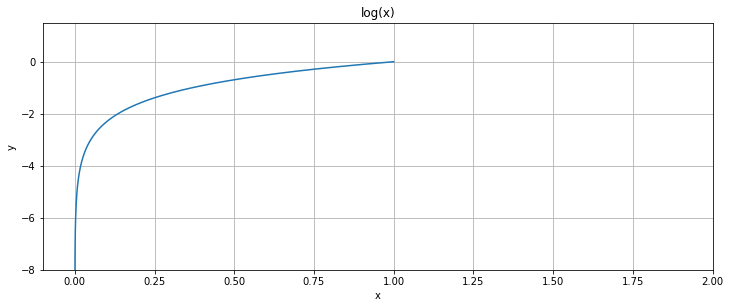

In [22]:
%matplotlib inline
from matplotlib.pyplot import figure, show
from numpy import arange, sin, pi

#t = arange(1e-5, 5.0, 0.00001)
#t = arange(1.0, 5.0, 0.00001) # computer scientists
t = arange(0.0, 1.0, 0.00001)  # data     scientists

fig = figure(1,figsize=(12, 10))

ax1 = fig.add_subplot(211)
ax1.plot(t, np.log(t))
ax1.grid(True)
ax1.set_ylim((-8, 1.5))
ax1.set_xlim((-0.1, 2))
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('log(x)')

show()

Confusion matrix, without normalization
[[ 21   1   0   0   0   0   0]
 [  4 197  48   0   0   0   0]
 [  0  52 131   4   0   0   0]
 [  0   0   8   6   0   0   0]
 [  0   8   0   0   0   0   0]
 [ 10   7   0   0   0   0   0]
 [  3   0   0   0   0   0   0]]
Normalized confusion matrix
[[0.95 0.05 0.   0.   0.   0.   0.  ]
 [0.02 0.79 0.19 0.   0.   0.   0.  ]
 [0.   0.28 0.7  0.02 0.   0.   0.  ]
 [0.   0.   0.57 0.43 0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.  ]
 [0.59 0.41 0.   0.   0.   0.   0.  ]
 [1.   0.   0.   0.   0.   0.   0.  ]]


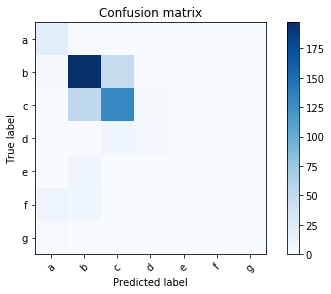

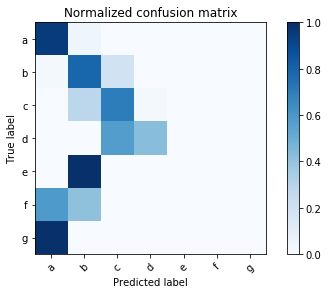

In [23]:
import numpy as np
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_compare, pred)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm, products)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, products, title='Normalized confusion matrix')

plt.show()

# Part 4.3: Keras Regression for Deep Neural Networks with RMSE

Regression results are evaluated differently than classification.  Consider the following code that trains a neural network for regression on the data set **jh-simple-dataset.csv**.  

In [24]:
import pandas as pd
from scipy.stats import zscore
from sklearn.model_selection import train_test_split

# Read the data set
df = pd.read_csv(
    "https://data.heatonresearch.com/data/t81-558/jh-simple-dataset.csv",
    na_values=['NA','?'])

# Generate dummies for job
df = pd.concat([df,pd.get_dummies(df['job'],prefix="job")],axis=1)
df.drop('job', axis=1, inplace=True)

# Generate dummies for area
df = pd.concat([df,pd.get_dummies(df['area'],prefix="area")],axis=1)
df.drop('area', axis=1, inplace=True)

# Generate dummies for product
df = pd.concat([df,pd.get_dummies(df['product'],prefix="product")],axis=1)
df.drop('product', axis=1, inplace=True)

# Missing values for income
med = df['income'].median()
df['income'] = df['income'].fillna(med)

# Standardize ranges
df['income'] = zscore(df['income'])
df['aspect'] = zscore(df['aspect'])
df['save_rate'] = zscore(df['save_rate'])
df['subscriptions'] = zscore(df['subscriptions'])

# Convert to numpy - Classification
x_columns = df.columns.drop('age').drop('id')
x = df[x_columns].values
y = df['age'].values

# Create train/test
x_train, x_test, y_train, y_test = train_test_split(    
    x, y, test_size=0.25, random_state=42)

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping

# Build the neural network
model = Sequential()
model.add(Dense(25, input_dim=x.shape[1], activation='relu')) # Hidden 1
model.add(Dense(10, activation='relu')) # Hidden 2
model.add(Dense(1)) # Output
model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, 
                        patience=5, verbose=1, mode='auto', restore_best_weights=True)
model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=1000)


Train on 1500 samples, validate on 500 samples
Epoch 1/1000
1500/1500 - 0s - loss: 1291.2652 - val_loss: 708.7741
Epoch 2/1000
1500/1500 - 0s - loss: 425.2953 - val_loss: 281.7181
Epoch 3/1000
1500/1500 - 0s - loss: 271.6409 - val_loss: 248.4978
Epoch 4/1000
1500/1500 - 0s - loss: 234.6398 - val_loss: 212.6591
Epoch 5/1000
1500/1500 - 0s - loss: 196.8156 - val_loss: 177.3978
Epoch 6/1000
1500/1500 - 0s - loss: 161.2660 - val_loss: 144.7355
Epoch 7/1000
1500/1500 - 0s - loss: 128.3759 - val_loss: 116.1912
Epoch 8/1000
1500/1500 - 0s - loss: 100.7649 - val_loss: 91.6614
Epoch 9/1000
1500/1500 - 0s - loss: 79.9847 - val_loss: 75.1676
Epoch 10/1000
1500/1500 - 0s - loss: 64.4110 - val_loss: 62.0538
Epoch 11/1000
1500/1500 - 0s - loss: 53.0824 - val_loss: 52.9741
Epoch 12/1000
1500/1500 - 0s - loss: 44.7256 - val_loss: 45.6306
Epoch 13/1000
1500/1500 - 0s - loss: 38.2273 - val_loss: 39.8843
Epoch 14/1000
1500/1500 - 0s - loss: 33.3108 - val_loss: 35.0754
Epoch 15/1000
1500/1500 - 0s - loss:

Epoch 129/1000
1500/1500 - 0s - loss: 0.5049 - val_loss: 0.6640
Epoch 130/1000
1500/1500 - 0s - loss: 0.4870 - val_loss: 0.6105
Epoch 131/1000
1500/1500 - 0s - loss: 0.5168 - val_loss: 0.6185
Epoch 132/1000
1500/1500 - 0s - loss: 0.4741 - val_loss: 0.5770
Epoch 133/1000
1500/1500 - 0s - loss: 0.4925 - val_loss: 0.5845
Epoch 134/1000
1500/1500 - 0s - loss: 0.4985 - val_loss: 0.7260
Epoch 135/1000
1500/1500 - 0s - loss: 0.4776 - val_loss: 0.6062
Epoch 136/1000
1500/1500 - 0s - loss: 0.4864 - val_loss: 0.5929
Epoch 137/1000
1500/1500 - 0s - loss: 0.4657 - val_loss: 0.5705
Epoch 138/1000
1500/1500 - 0s - loss: 0.5092 - val_loss: 0.5654
Epoch 139/1000
1500/1500 - 0s - loss: 0.4860 - val_loss: 0.5702
Epoch 140/1000
1500/1500 - 0s - loss: 0.4608 - val_loss: 0.5795
Epoch 141/1000
1500/1500 - 0s - loss: 0.5068 - val_loss: 0.5845
Epoch 142/1000
1500/1500 - 0s - loss: 0.4717 - val_loss: 0.6156
Epoch 143/1000
Restoring model weights from the end of the best epoch.
1500/1500 - 0s - loss: 0.4676 - v

### Mean Square Error

The mean square error is the sum of the squared differences between the prediction ($\hat{y}$) and the expected ($y$).  MSE values are not of a particular unit.  If an MSE value has decreased for a model, that is good.  However, beyond this, there is not much more you can determine.  Low MSE values are desired.

$ \text{MSE} = \frac{1}{n} \sum_{i=1}^n \left(\hat{y}_i - y_i\right)^2 $


In [26]:
from sklearn import metrics

# Predict
pred = model.predict(x_test)

# Measure MSE error.  
score = metrics.mean_squared_error(pred,y_test)
print("Final score (MSE): {}".format(score))

Final score (MSE): 0.5653711293296073


### Root Mean Square Error

The root mean square (RMSE) is essentially the square root of the MSE.  Because of this, the RMSE error is in the same units as the training data outcome. Low RMSE values are desired.

$ \text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^n \left(\hat{y}_i - y_i\right)^2} $

In [27]:
import numpy as np

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

Final score (RMSE): 0.7519116499493855


### Lift Chart


To generate a lift chart, perform the following activities:

* Sort the data by expected output. Plot the blue line above.
* For every point on the x-axis plot the predicted value for that same data point. This is the green line above.
* The x-axis is just 0 to 100% of the dataset. The expected always starts low and ends high.
* The y-axis is ranged according to the values predicted.

Reading a lift chart:

* The expected and predict lines should be close. Notice where one is above the ot other.
* The below chart is the most accurate on lower age.

In [28]:
# Regression chart.
def chart_regression(pred, y, sort=True):
    t = pd.DataFrame({'pred': pred, 'y': y.flatten()})
    if sort:
        t.sort_values(by=['y'], inplace=True)
    plt.plot(t['y'].tolist(), label='expected')
    plt.plot(t['pred'].tolist(), label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

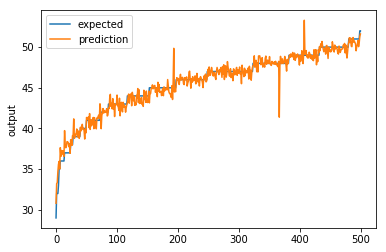

In [29]:
# Plot the chart
chart_regression(pred.flatten(),y_test)

# Part 4.4: Training Neural Networks

# Classic Backpropagation
Backpropagation is the primary means by which a neural network's weights are determined during training. Backpropagation works by calculating a weight change amount ($v_t$) for every weight($\theta$, theata) in the neural network.  This value is subtracted from every weight by the following equation: 

$ \theta_t = \theta_{t-1} - v_t $

This process is repeated for every iteration($t$).  How the weight change is calculated depends on the training algorithm.  Classic backpropagation simply calculates a gradient ($\nabla$, nabla) for every weight in the neural network with respect to the error function ($J$) of the neural network.  The gradient is scaled by a learning rate ($\eta$, eta).

$ v_t = \eta \nabla_{\theta_{t-1}} J(\theta_{t-1}) $

The learning rate is an important concept for backpropagation training.  Setting the learning rate can be complex:

* Too low of a learning rate will usually converge to a good solution; however, the process will be very slow.
* Too high of a learning rate will either fail outright, or converge to a higher error than a better learning rate.

Common values for learning rate are: 0.1, 0.01, 0.001, etc.

Gradients:

![Derivative](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_2_deriv.png "Derivative")

The following link, from the book, shows how a simple [neural network is trained with backpropagation](http://www.heatonresearch.com/aifh/vol3/).

### Momentum Backpropagation

Momentum adds another term to the calculation of $v_t$:

$ v_t = \eta \nabla_{\theta_{t-1}} J(\theta_{t-1}) + \lambda v_{t-1} $

Like the learning rate, momentum adds another training parameter that scales the effect of momentum.  Momentum backpropagation has two training parameters: learning rate ($\eta$, eta) and momentum ($\lambda$, lambda).  Momentum simply adds the scaled value of the previous weight change amount ($v_{t-1}$) to the current weight change amount($v_t$).

This has the effect of adding additional force behind a direction a weight was moving.  This might allow the weight to escape a local minima:

![Momentum](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_5_momentum.png "Momentum")

A very common value for momentum is 0.9.


### Batch and Online Backpropagation

How often should the weights of a neural network be updated?  Gradients can be calculated for a training set element.  These gradients can also be summed together into batches and the weights updated once per batch.

* **Online Training** - Update the weights based on gradients calculated from a single training set element.
* **Batch Training** - Update the weights based on the sum of the gradients over all training set elements.
* **Batch Size** - Update the weights based on the sum of some batch size of training set elements.
* **Mini-Batch Training** - The same as batch size, but with a very small batch size.  Mini-batches are very popular and they are often in the 32-64 element range.

Because the batch size is smaller than the complete training set size, it may take several batches to make it completely through the training set.  

* **Step/Iteration** - The number of batches that were processed.
* **Epoch** - The number of times the complete training set was processed.


# Stochastic Gradient Descent

Stochastic gradient descent (SGD) is currently one of the most popular neural network training algorithms.  It works very similarly to Batch/Mini-Batch training, except that the batches are made up of a random set of training elements.

This leads to a very irregular convergence in error during training:

![SGD Error](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_5_sgd_error.png "SGD Error")
[Image from Wikipedia](https://en.wikipedia.org/wiki/Stochastic_gradient_descent)

Because the neural network is trained on a random sample of the complete training set each time, the error does not make a smooth transition downward.  However, the error usually does go down.

Advantages to SGD include:

* Computationally efficient.  Even with a very large training set, each training step can be relatively fast.
* Decreases overfitting by focusing on only a portion of the training set each step.


### Other Techniques

One problem with simple backpropagation training algorithms is that they are highly sensative to learning rate and momentum.  This is difficult because:

* Learning rate must be adjusted to a small enough level to train an accurate neural network.
* Momentum must be large enough to overcome local minima, yet small enough to not destabilize the training.
* A single learning rate/momentum is often not good enough for the entire training process. It is often useful to automatically decrease learning rate as the training progresses.
* All weights share a single learning rate/momentum.

Other training techniques:

* **Resilient Propagation** - Use only the magnitude of the gradient and allow each neuron to learn at its own rate.  No need for learning rate/momentum; however, only works in full batch mode.
* **Nesterov accelerated gradient** - Helps mitigate the risk of choosing a bad mini-batch.
* **Adagrad** - Allows an automatically decaying per-weight learning rate and momentum concept.
* **Adadelta** - Extension of Adagrad that seeks to reduce its aggressive, monotonically decreasing learning rate.
* **Non-Gradient Methods** - Non-gradient methods can *sometimes* be useful, though rarely outperform gradient-based backpropagation methods.  These include: [simulated annealing](https://en.wikipedia.org/wiki/Simulated_annealing), [genetic algorithms](https://en.wikipedia.org/wiki/Genetic_algorithm), [particle swarm optimization](https://en.wikipedia.org/wiki/Particle_swarm_optimization), [Nelder Mead](https://en.wikipedia.org/wiki/Nelder%E2%80%93Mead_method), and [many more](https://en.wikipedia.org/wiki/Category:Optimization_algorithms_and_methods).

### ADAM Update

ADAM is the first training algorithm you should try.  It is very effective.  Kingma and Ba (2014) introduced the Adam update rule that derives its name from the adaptive moment estimates that it uses.  Adam estimates the first (mean) and second (variance) moments to determine the weight corrections.  Adam begins with an exponentially decaying average of past gradients (m):

$ m_t = \beta_1 m_{t-1} + (1-\beta_1) g_t $

This average accomplishes a similar goal as classic momentum update; however, its value is calculated automatically based on the current gradient ($g_t$).  The update rule then calculates the second moment ($v_t$):

$ v_t = \beta_2 v_{t-1} + (1-\beta_2) g_t^2 $

The values $m_t$ and $v_t$ are estimates of the first moment (the mean) and the second moment (the uncentered variance) of the gradients respectively.  However, they will have a strong bias towards zero in the initial training cycles.  The first moment’s bias is corrected as follows.

$ \hat{m}_t = \frac{m_t}{1-\beta^t_1} $

Similarly, the second moment is also corrected:

$ \hat{v}_t = \frac{v_t}{1-\beta_2^t} $

These bias-corrected first and second moment estimates are applied to the ultimate Adam update rule, as follows:

$ \theta_t = \theta_{t-1} - \frac{\alpha \cdot \hat{m}_t}{\sqrt{\hat{v}_t}+\eta} \hat{m}_t $

Adam is very tolerant to initial learning rate (\alpha) and other training parameters. Kingma and Ba (2014)  propose default values of 0.9 for $\beta_1$, 0.999 for $\beta_2$, and 10-8 for $\eta$.

### Methods Compared

The following image shows how each of these algorithms train (image credits: [author](Alec Radford), [where I found it](http://sebastianruder.com/optimizing-gradient-descent/index.html#visualizationofalgorithms) ):

![Training Techniques](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/contours_evaluation_optimizers.gif "Training Techniques")



### Specifying the Update Rule in Tensorflow

TensorFlow allows the update rule to be set to one of:

* Adagrad
* **Adam**
* Ftrl
* Momentum
* RMSProp
* **SGD**



Restoring model weights from the end of the best epoch.
Epoch 00120: early stopping


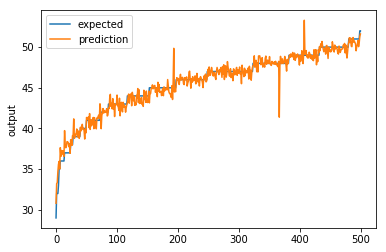

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
import pandas as pd

# Read the data set
df = pd.read_csv(
    "https://data.heatonresearch.com/data/t81-558/jh-simple-dataset.csv",
    na_values=['NA','?'])

# Generate dummies for job
df = pd.concat([df,pd.get_dummies(df['job'],prefix="job")],axis=1)
df.drop('job', axis=1, inplace=True)

# Generate dummies for area
df = pd.concat([df,pd.get_dummies(df['area'],prefix="area")],axis=1)
df.drop('area', axis=1, inplace=True)

# Generate dummies for product
df = pd.concat([df,pd.get_dummies(df['product'],prefix="product")],axis=1)
df.drop('product', axis=1, inplace=True)

# Missing values for income
med = df['income'].median()
df['income'] = df['income'].fillna(med)

# Standardize ranges
df['income'] = zscore(df['income'])
df['aspect'] = zscore(df['aspect'])
df['save_rate'] = zscore(df['save_rate'])
df['subscriptions'] = zscore(df['subscriptions'])

# Convert to numpy - Classification
x_columns = df.columns.drop('age').drop('id')
x = df[x_columns].values
y = df['age'].values

# Create train/test
x_train, x_test, y_train, y_test = train_test_split(    
    x, y, test_size=0.25, random_state=42)

# Build the neural network
model = Sequential()
model.add(Dense(25, input_dim=x.shape[1], activation='relu')) # Hidden 1
model.add(Dense(10, activation='relu')) # Hidden 2
model.add(Dense(1)) # Output
model.compile(loss='mean_squared_error', optimizer='adam') # Modify here
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, 
                        verbose=1, mode='auto', restore_best_weights=True)
model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=0,epochs=1000)

# Plot the chart
chart_regression(pred.flatten(),y_test)

# Part 4.5: Error Calculation from Scratch

We will now look at how to calculate RMSE and logloss by hand.  


### Regression

In [31]:
from sklearn import metrics
import numpy as np

predicted = [1.1,1.9,3.4,4.2,4.3]
expected = [1,2,3,4,5]

score_mse = metrics.mean_squared_error(predicted,expected)
score_rmse = np.sqrt(score_mse)
print("Score (MSE): {}".format(score_mse))
print("Score (RMSE): {}".format(score_rmse))


Score (MSE): 0.14200000000000007
Score (RMSE): 0.37682887362833556


In [32]:
score_mse = ((predicted[0]-expected[0])**2 + (predicted[1]-expected[1])**2 
+ (predicted[2]-expected[2])**2 + (predicted[3]-expected[3])**2
+ (predicted[4]-expected[4])**2)/len(predicted)
score_rmse = np.sqrt(score_mse)
    
print("Score (MSE): {}".format(score_mse))
print("Score (RMSE): {}".format(score_rmse))

Score (MSE): 0.14200000000000007
Score (RMSE): 0.37682887362833556


### Classification

We will now look at how to calculate a logloss by hand. For this we look at a binary prediction. The expected is always 0 or 1. The predicted is some number between 0-1 that indicates the probability true (1). Therefore, a prediction of 1.0 is completely correct if the expected is 1 and completely wrong if the expected is 0.

In [33]:
from sklearn import metrics

expected = [1,1,0,0,0]
predicted = [0.9,0.99,0.1,0.05,0.06]

print(metrics.log_loss(expected,predicted))

0.06678801305495843


Now we attempt to calculate the same logloss manually.

In [34]:
import numpy as np

score_logloss = (np.log(1.0-np.abs(expected[0]-predicted[0]))+\
np.log(1.0-np.abs(expected[1]-predicted[1]))+\
np.log(1.0-np.abs(expected[2]-predicted[2]))+\
np.log(1.0-np.abs(expected[3]-predicted[3]))+\
np.log(1.0-np.abs(expected[4]-predicted[4])))\
*(-1/len(predicted))

print(f'Score Logloss {score_logloss}')

Score Logloss 0.06678801305495843


# Module 4 Assignment

You can find the first assignment here: [assignment 4](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/assignments/assignment_yourname_class1.ipynb)